In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def weight_variable(name, shape):
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=tf.initializers.glorot_uniform)

def bias_variable(name, shape):
    return tf.get_variable(name=name, dtype=tf.float32,
                          initializer=tf.constant(0., shape=shape))

## Time-Series Forcasting

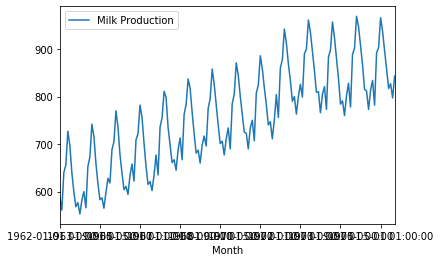

In [3]:
"""
Credit to https://www.udemy.com/course/complete-guide-to-tensorflow-for-deep-learning-with-python
"""

sample_data = pd.read_csv('data/monthly-milk-production.csv', index_col='Month')
sample_data.plot()
sample_data.head()

seq = sample_data['Milk Production'].values
test_seq = seq[-12:]
train_seq = seq[:-12]

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_seq = scaler.fit_transform(train_seq.reshape(-1, 1))
test_seq = scaler.transform(test_seq.reshape(-1, 1))

In [5]:
n_in = 1
n_out = 1
batch_size = 1
time_step_size = 12
n_hid = 100

learning_rate = 0.001
epochs = 10000

In [6]:
def next_batch(seq, time_step_size, batch_size):
    y_batch = []
    for i in range(batch_size):
        start_index = np.random.randint(0, high=len(seq) - time_step_size)
        y_batch.append(seq[start_index:start_index + time_step_size + 1].reshape(
            1, time_step_size + 1, -1))
        
    y_batch = np.concatenate(y_batch, axis=0)
    
    return y_batch[:,:-1, :], y_batch[:, 1:, :]

In [7]:
_x, _y = next_batch(train_seq, time_step_size, batch_size)
print(_x.shape) # (batch_size, time_step_size,embedding_size, )

(1, 12, 1)


In [8]:
"""
Model Definition
"""
x = tf.placeholder(tf.float32, [None, time_step_size, n_in])
y = tf.placeholder(tf.float32, [None, time_step_size, n_out])

cell = tf.nn.rnn_cell.BasicLSTMCell(n_hid, activation=tf.nn.relu)
output, memory = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

W = weight_variable('W', [n_hid, n_out])
b = bias_variable('b', [n_out])

y_pred = tf.nn.relu(tf.matmul(output, W) + b)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
loss = tf.reduce_mean(tf.square(y - y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [10]:
writer = tf.summary.FileWriter('logs/', tf.get_default_graph())
tf.summary.scalar('training_loss', loss)
summaries = tf.summary.merge_all()

In [11]:
list(train_seq[-12:, :].squeeze())


[0.6610576923076923,
 0.5408653846153846,
 0.8076923076923077,
 0.8389423076923077,
 1.0000000000000002,
 0.9471153846153848,
 0.8533653846153848,
 0.7548076923076923,
 0.6298076923076923,
 0.622596153846154,
 0.528846153846154,
 0.625]

In [12]:
predicted_seq = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        x_batch, y_batch = next_batch(train_seq, time_step_size, batch_size)
        
        _, loss_step, _summary = sess.run([train, loss, summaries], 
                                          feed_dict={x: x_batch, y: y_batch})
        writer.add_summary(_summary, global_step=i)
        print(f'Epoch {i}:\tTraining Loss - {loss_step:.04f}')
        
    
    seq = list(train_seq[-12:, :].squeeze())
    
    for j in range(12):
        x_batch = np.array(seq[-12:]).reshape(1, time_step_size, -1)
        pred = sess.run(y_pred, feed_dict={x:x_batch})
        seq.append(pred[0,-1, 0])
        

Epoch 0:	Training Loss - 0.2347
Epoch 1:	Training Loss - 0.0521
Epoch 2:	Training Loss - 0.2731
Epoch 3:	Training Loss - 0.0846
Epoch 4:	Training Loss - 0.1967
Epoch 5:	Training Loss - 0.4338
Epoch 6:	Training Loss - 0.3871
Epoch 7:	Training Loss - 0.1533
Epoch 8:	Training Loss - 0.1548
Epoch 9:	Training Loss - 0.0790
Epoch 10:	Training Loss - 0.0266
Epoch 11:	Training Loss - 0.2948
Epoch 12:	Training Loss - 0.2812
Epoch 13:	Training Loss - 0.0726
Epoch 14:	Training Loss - 0.2507
Epoch 15:	Training Loss - 0.0753
Epoch 16:	Training Loss - 0.2268
Epoch 17:	Training Loss - 0.0271
Epoch 18:	Training Loss - 0.1913
Epoch 19:	Training Loss - 0.0454
Epoch 20:	Training Loss - 0.0405
Epoch 21:	Training Loss - 0.1484
Epoch 22:	Training Loss - 0.0439
Epoch 23:	Training Loss - 0.0343
Epoch 24:	Training Loss - 0.0449
Epoch 25:	Training Loss - 0.1247
Epoch 26:	Training Loss - 0.1545
Epoch 27:	Training Loss - 0.0718
Epoch 28:	Training Loss - 0.0805
Epoch 29:	Training Loss - 0.1062
Epoch 30:	Training L

Epoch 253:	Training Loss - 0.0532
Epoch 254:	Training Loss - 0.0175
Epoch 255:	Training Loss - 0.0350
Epoch 256:	Training Loss - 0.0305
Epoch 257:	Training Loss - 0.0339
Epoch 258:	Training Loss - 0.0275
Epoch 259:	Training Loss - 0.0201
Epoch 260:	Training Loss - 0.0202
Epoch 261:	Training Loss - 0.0157
Epoch 262:	Training Loss - 0.0501
Epoch 263:	Training Loss - 0.0193
Epoch 264:	Training Loss - 0.0304
Epoch 265:	Training Loss - 0.0168
Epoch 266:	Training Loss - 0.0304
Epoch 267:	Training Loss - 0.0230
Epoch 268:	Training Loss - 0.0193
Epoch 269:	Training Loss - 0.0261
Epoch 270:	Training Loss - 0.0265
Epoch 271:	Training Loss - 0.0237
Epoch 272:	Training Loss - 0.0118
Epoch 273:	Training Loss - 0.0206
Epoch 274:	Training Loss - 0.0251
Epoch 275:	Training Loss - 0.0308
Epoch 276:	Training Loss - 0.0486
Epoch 277:	Training Loss - 0.0143
Epoch 278:	Training Loss - 0.0431
Epoch 279:	Training Loss - 0.0325
Epoch 280:	Training Loss - 0.0224
Epoch 281:	Training Loss - 0.0164
Epoch 282:	Tra

Epoch 498:	Training Loss - 0.0094
Epoch 499:	Training Loss - 0.0102
Epoch 500:	Training Loss - 0.0111
Epoch 501:	Training Loss - 0.0227
Epoch 502:	Training Loss - 0.0166
Epoch 503:	Training Loss - 0.0073
Epoch 504:	Training Loss - 0.0068
Epoch 505:	Training Loss - 0.0140
Epoch 506:	Training Loss - 0.0106
Epoch 507:	Training Loss - 0.0069
Epoch 508:	Training Loss - 0.0196
Epoch 509:	Training Loss - 0.0151
Epoch 510:	Training Loss - 0.0132
Epoch 511:	Training Loss - 0.0191
Epoch 512:	Training Loss - 0.0111
Epoch 513:	Training Loss - 0.0170
Epoch 514:	Training Loss - 0.0168
Epoch 515:	Training Loss - 0.0137
Epoch 516:	Training Loss - 0.0129
Epoch 517:	Training Loss - 0.0120
Epoch 518:	Training Loss - 0.0123
Epoch 519:	Training Loss - 0.0159
Epoch 520:	Training Loss - 0.0224
Epoch 521:	Training Loss - 0.0132
Epoch 522:	Training Loss - 0.0135
Epoch 523:	Training Loss - 0.0094
Epoch 524:	Training Loss - 0.0220
Epoch 525:	Training Loss - 0.0120
Epoch 526:	Training Loss - 0.0180
Epoch 527:	Tra

Epoch 745:	Training Loss - 0.0120
Epoch 746:	Training Loss - 0.0221
Epoch 747:	Training Loss - 0.0170
Epoch 748:	Training Loss - 0.0200
Epoch 749:	Training Loss - 0.0129
Epoch 750:	Training Loss - 0.0133
Epoch 751:	Training Loss - 0.0099
Epoch 752:	Training Loss - 0.0115
Epoch 753:	Training Loss - 0.0123
Epoch 754:	Training Loss - 0.0077
Epoch 755:	Training Loss - 0.0109
Epoch 756:	Training Loss - 0.0084
Epoch 757:	Training Loss - 0.0124
Epoch 758:	Training Loss - 0.0089
Epoch 759:	Training Loss - 0.0170
Epoch 760:	Training Loss - 0.0097
Epoch 761:	Training Loss - 0.0093
Epoch 762:	Training Loss - 0.0057
Epoch 763:	Training Loss - 0.0218
Epoch 764:	Training Loss - 0.0101
Epoch 765:	Training Loss - 0.0141
Epoch 766:	Training Loss - 0.0136
Epoch 767:	Training Loss - 0.0054
Epoch 768:	Training Loss - 0.0153
Epoch 769:	Training Loss - 0.0056
Epoch 770:	Training Loss - 0.0098
Epoch 771:	Training Loss - 0.0131
Epoch 772:	Training Loss - 0.0108
Epoch 773:	Training Loss - 0.0060
Epoch 774:	Tra

Epoch 1021:	Training Loss - 0.0099
Epoch 1022:	Training Loss - 0.0112
Epoch 1023:	Training Loss - 0.0121
Epoch 1024:	Training Loss - 0.0084
Epoch 1025:	Training Loss - 0.0102
Epoch 1026:	Training Loss - 0.0118
Epoch 1027:	Training Loss - 0.0076
Epoch 1028:	Training Loss - 0.0153
Epoch 1029:	Training Loss - 0.0068
Epoch 1030:	Training Loss - 0.0097
Epoch 1031:	Training Loss - 0.0098
Epoch 1032:	Training Loss - 0.0089
Epoch 1033:	Training Loss - 0.0100
Epoch 1034:	Training Loss - 0.0086
Epoch 1035:	Training Loss - 0.0060
Epoch 1036:	Training Loss - 0.0078
Epoch 1037:	Training Loss - 0.0093
Epoch 1038:	Training Loss - 0.0068
Epoch 1039:	Training Loss - 0.0082
Epoch 1040:	Training Loss - 0.0082
Epoch 1041:	Training Loss - 0.0104
Epoch 1042:	Training Loss - 0.0093
Epoch 1043:	Training Loss - 0.0125
Epoch 1044:	Training Loss - 0.0085
Epoch 1045:	Training Loss - 0.0117
Epoch 1046:	Training Loss - 0.0165
Epoch 1047:	Training Loss - 0.0083
Epoch 1048:	Training Loss - 0.0095
Epoch 1049:	Training

Epoch 1259:	Training Loss - 0.0088
Epoch 1260:	Training Loss - 0.0085
Epoch 1261:	Training Loss - 0.0080
Epoch 1262:	Training Loss - 0.0053
Epoch 1263:	Training Loss - 0.0099
Epoch 1264:	Training Loss - 0.0088
Epoch 1265:	Training Loss - 0.0134
Epoch 1266:	Training Loss - 0.0082
Epoch 1267:	Training Loss - 0.0097
Epoch 1268:	Training Loss - 0.0084
Epoch 1269:	Training Loss - 0.0078
Epoch 1270:	Training Loss - 0.0095
Epoch 1271:	Training Loss - 0.0082
Epoch 1272:	Training Loss - 0.0075
Epoch 1273:	Training Loss - 0.0081
Epoch 1274:	Training Loss - 0.0088
Epoch 1275:	Training Loss - 0.0071
Epoch 1276:	Training Loss - 0.0078
Epoch 1277:	Training Loss - 0.0067
Epoch 1278:	Training Loss - 0.0076
Epoch 1279:	Training Loss - 0.0079
Epoch 1280:	Training Loss - 0.0099
Epoch 1281:	Training Loss - 0.0109
Epoch 1282:	Training Loss - 0.0092
Epoch 1283:	Training Loss - 0.0109
Epoch 1284:	Training Loss - 0.0080
Epoch 1285:	Training Loss - 0.0062
Epoch 1286:	Training Loss - 0.0088
Epoch 1287:	Training

Epoch 1508:	Training Loss - 0.0088
Epoch 1509:	Training Loss - 0.0068
Epoch 1510:	Training Loss - 0.0068
Epoch 1511:	Training Loss - 0.0073
Epoch 1512:	Training Loss - 0.0079
Epoch 1513:	Training Loss - 0.0065
Epoch 1514:	Training Loss - 0.0093
Epoch 1515:	Training Loss - 0.0062
Epoch 1516:	Training Loss - 0.0081
Epoch 1517:	Training Loss - 0.0050
Epoch 1518:	Training Loss - 0.0109
Epoch 1519:	Training Loss - 0.0060
Epoch 1520:	Training Loss - 0.0101
Epoch 1521:	Training Loss - 0.0109
Epoch 1522:	Training Loss - 0.0093
Epoch 1523:	Training Loss - 0.0099
Epoch 1524:	Training Loss - 0.0091
Epoch 1525:	Training Loss - 0.0100
Epoch 1526:	Training Loss - 0.0069
Epoch 1527:	Training Loss - 0.0112
Epoch 1528:	Training Loss - 0.0081
Epoch 1529:	Training Loss - 0.0101
Epoch 1530:	Training Loss - 0.0080
Epoch 1531:	Training Loss - 0.0066
Epoch 1532:	Training Loss - 0.0081
Epoch 1533:	Training Loss - 0.0085
Epoch 1534:	Training Loss - 0.0061
Epoch 1535:	Training Loss - 0.0066
Epoch 1536:	Training

Epoch 1745:	Training Loss - 0.0073
Epoch 1746:	Training Loss - 0.0057
Epoch 1747:	Training Loss - 0.0092
Epoch 1748:	Training Loss - 0.0069
Epoch 1749:	Training Loss - 0.0079
Epoch 1750:	Training Loss - 0.0061
Epoch 1751:	Training Loss - 0.0068
Epoch 1752:	Training Loss - 0.0074
Epoch 1753:	Training Loss - 0.0057
Epoch 1754:	Training Loss - 0.0093
Epoch 1755:	Training Loss - 0.0075
Epoch 1756:	Training Loss - 0.0088
Epoch 1757:	Training Loss - 0.0064
Epoch 1758:	Training Loss - 0.0073
Epoch 1759:	Training Loss - 0.0053
Epoch 1760:	Training Loss - 0.0062
Epoch 1761:	Training Loss - 0.0053
Epoch 1762:	Training Loss - 0.0107
Epoch 1763:	Training Loss - 0.0072
Epoch 1764:	Training Loss - 0.0067
Epoch 1765:	Training Loss - 0.0066
Epoch 1766:	Training Loss - 0.0066
Epoch 1767:	Training Loss - 0.0066
Epoch 1768:	Training Loss - 0.0070
Epoch 1769:	Training Loss - 0.0114
Epoch 1770:	Training Loss - 0.0048
Epoch 1771:	Training Loss - 0.0075
Epoch 1772:	Training Loss - 0.0099
Epoch 1773:	Training

Epoch 2004:	Training Loss - 0.0066
Epoch 2005:	Training Loss - 0.0078
Epoch 2006:	Training Loss - 0.0082
Epoch 2007:	Training Loss - 0.0077
Epoch 2008:	Training Loss - 0.0111
Epoch 2009:	Training Loss - 0.0031
Epoch 2010:	Training Loss - 0.0057
Epoch 2011:	Training Loss - 0.0060
Epoch 2012:	Training Loss - 0.0072
Epoch 2013:	Training Loss - 0.0080
Epoch 2014:	Training Loss - 0.0068
Epoch 2015:	Training Loss - 0.0056
Epoch 2016:	Training Loss - 0.0063
Epoch 2017:	Training Loss - 0.0075
Epoch 2018:	Training Loss - 0.0081
Epoch 2019:	Training Loss - 0.0072
Epoch 2020:	Training Loss - 0.0079
Epoch 2021:	Training Loss - 0.0039
Epoch 2022:	Training Loss - 0.0118
Epoch 2023:	Training Loss - 0.0067
Epoch 2024:	Training Loss - 0.0063
Epoch 2025:	Training Loss - 0.0086
Epoch 2026:	Training Loss - 0.0065
Epoch 2027:	Training Loss - 0.0084
Epoch 2028:	Training Loss - 0.0086
Epoch 2029:	Training Loss - 0.0057
Epoch 2030:	Training Loss - 0.0037
Epoch 2031:	Training Loss - 0.0063
Epoch 2032:	Training

Epoch 2269:	Training Loss - 0.0074
Epoch 2270:	Training Loss - 0.0042
Epoch 2271:	Training Loss - 0.0079
Epoch 2272:	Training Loss - 0.0077
Epoch 2273:	Training Loss - 0.0062
Epoch 2274:	Training Loss - 0.0063
Epoch 2275:	Training Loss - 0.0107
Epoch 2276:	Training Loss - 0.0050
Epoch 2277:	Training Loss - 0.0122
Epoch 2278:	Training Loss - 0.0076
Epoch 2279:	Training Loss - 0.0076
Epoch 2280:	Training Loss - 0.0098
Epoch 2281:	Training Loss - 0.0057
Epoch 2282:	Training Loss - 0.0040
Epoch 2283:	Training Loss - 0.0057
Epoch 2284:	Training Loss - 0.0062
Epoch 2285:	Training Loss - 0.0109
Epoch 2286:	Training Loss - 0.0035
Epoch 2287:	Training Loss - 0.0071
Epoch 2288:	Training Loss - 0.0074
Epoch 2289:	Training Loss - 0.0079
Epoch 2290:	Training Loss - 0.0054
Epoch 2291:	Training Loss - 0.0076
Epoch 2292:	Training Loss - 0.0082
Epoch 2293:	Training Loss - 0.0059
Epoch 2294:	Training Loss - 0.0051
Epoch 2295:	Training Loss - 0.0071
Epoch 2296:	Training Loss - 0.0061
Epoch 2297:	Training

Epoch 2511:	Training Loss - 0.0058
Epoch 2512:	Training Loss - 0.0056
Epoch 2513:	Training Loss - 0.0037
Epoch 2514:	Training Loss - 0.0100
Epoch 2515:	Training Loss - 0.0084
Epoch 2516:	Training Loss - 0.0098
Epoch 2517:	Training Loss - 0.0048
Epoch 2518:	Training Loss - 0.0043
Epoch 2519:	Training Loss - 0.0080
Epoch 2520:	Training Loss - 0.0049
Epoch 2521:	Training Loss - 0.0063
Epoch 2522:	Training Loss - 0.0083
Epoch 2523:	Training Loss - 0.0099
Epoch 2524:	Training Loss - 0.0070
Epoch 2525:	Training Loss - 0.0059
Epoch 2526:	Training Loss - 0.0070
Epoch 2527:	Training Loss - 0.0046
Epoch 2528:	Training Loss - 0.0066
Epoch 2529:	Training Loss - 0.0062
Epoch 2530:	Training Loss - 0.0043
Epoch 2531:	Training Loss - 0.0058
Epoch 2532:	Training Loss - 0.0053
Epoch 2533:	Training Loss - 0.0058
Epoch 2534:	Training Loss - 0.0061
Epoch 2535:	Training Loss - 0.0065
Epoch 2536:	Training Loss - 0.0072
Epoch 2537:	Training Loss - 0.0063
Epoch 2538:	Training Loss - 0.0029
Epoch 2539:	Training

Epoch 2752:	Training Loss - 0.0072
Epoch 2753:	Training Loss - 0.0040
Epoch 2754:	Training Loss - 0.0045
Epoch 2755:	Training Loss - 0.0077
Epoch 2756:	Training Loss - 0.0068
Epoch 2757:	Training Loss - 0.0037
Epoch 2758:	Training Loss - 0.0025
Epoch 2759:	Training Loss - 0.0106
Epoch 2760:	Training Loss - 0.0033
Epoch 2761:	Training Loss - 0.0072
Epoch 2762:	Training Loss - 0.0027
Epoch 2763:	Training Loss - 0.0080
Epoch 2764:	Training Loss - 0.0065
Epoch 2765:	Training Loss - 0.0050
Epoch 2766:	Training Loss - 0.0111
Epoch 2767:	Training Loss - 0.0034
Epoch 2768:	Training Loss - 0.0091
Epoch 2769:	Training Loss - 0.0076
Epoch 2770:	Training Loss - 0.0059
Epoch 2771:	Training Loss - 0.0041
Epoch 2772:	Training Loss - 0.0040
Epoch 2773:	Training Loss - 0.0072
Epoch 2774:	Training Loss - 0.0067
Epoch 2775:	Training Loss - 0.0055
Epoch 2776:	Training Loss - 0.0062
Epoch 2777:	Training Loss - 0.0062
Epoch 2778:	Training Loss - 0.0078
Epoch 2779:	Training Loss - 0.0049
Epoch 2780:	Training

Epoch 3007:	Training Loss - 0.0053
Epoch 3008:	Training Loss - 0.0030
Epoch 3009:	Training Loss - 0.0079
Epoch 3010:	Training Loss - 0.0046
Epoch 3011:	Training Loss - 0.0061
Epoch 3012:	Training Loss - 0.0099
Epoch 3013:	Training Loss - 0.0091
Epoch 3014:	Training Loss - 0.0095
Epoch 3015:	Training Loss - 0.0075
Epoch 3016:	Training Loss - 0.0045
Epoch 3017:	Training Loss - 0.0106
Epoch 3018:	Training Loss - 0.0062
Epoch 3019:	Training Loss - 0.0061
Epoch 3020:	Training Loss - 0.0063
Epoch 3021:	Training Loss - 0.0088
Epoch 3022:	Training Loss - 0.0077
Epoch 3023:	Training Loss - 0.0075
Epoch 3024:	Training Loss - 0.0084
Epoch 3025:	Training Loss - 0.0062
Epoch 3026:	Training Loss - 0.0083
Epoch 3027:	Training Loss - 0.0090
Epoch 3028:	Training Loss - 0.0064
Epoch 3029:	Training Loss - 0.0090
Epoch 3030:	Training Loss - 0.0050
Epoch 3031:	Training Loss - 0.0069
Epoch 3032:	Training Loss - 0.0044
Epoch 3033:	Training Loss - 0.0104
Epoch 3034:	Training Loss - 0.0056
Epoch 3035:	Training

Epoch 3256:	Training Loss - 0.0038
Epoch 3257:	Training Loss - 0.0084
Epoch 3258:	Training Loss - 0.0053
Epoch 3259:	Training Loss - 0.0048
Epoch 3260:	Training Loss - 0.0087
Epoch 3261:	Training Loss - 0.0078
Epoch 3262:	Training Loss - 0.0051
Epoch 3263:	Training Loss - 0.0086
Epoch 3264:	Training Loss - 0.0073
Epoch 3265:	Training Loss - 0.0076
Epoch 3266:	Training Loss - 0.0052
Epoch 3267:	Training Loss - 0.0062
Epoch 3268:	Training Loss - 0.0058
Epoch 3269:	Training Loss - 0.0053
Epoch 3270:	Training Loss - 0.0027
Epoch 3271:	Training Loss - 0.0071
Epoch 3272:	Training Loss - 0.0106
Epoch 3273:	Training Loss - 0.0130
Epoch 3274:	Training Loss - 0.0065
Epoch 3275:	Training Loss - 0.0075
Epoch 3276:	Training Loss - 0.0064
Epoch 3277:	Training Loss - 0.0031
Epoch 3278:	Training Loss - 0.0063
Epoch 3279:	Training Loss - 0.0039
Epoch 3280:	Training Loss - 0.0109
Epoch 3281:	Training Loss - 0.0063
Epoch 3282:	Training Loss - 0.0069
Epoch 3283:	Training Loss - 0.0056
Epoch 3284:	Training

Epoch 3527:	Training Loss - 0.0078
Epoch 3528:	Training Loss - 0.0106
Epoch 3529:	Training Loss - 0.0046
Epoch 3530:	Training Loss - 0.0073
Epoch 3531:	Training Loss - 0.0045
Epoch 3532:	Training Loss - 0.0060
Epoch 3533:	Training Loss - 0.0063
Epoch 3534:	Training Loss - 0.0045
Epoch 3535:	Training Loss - 0.0070
Epoch 3536:	Training Loss - 0.0052
Epoch 3537:	Training Loss - 0.0103
Epoch 3538:	Training Loss - 0.0063
Epoch 3539:	Training Loss - 0.0031
Epoch 3540:	Training Loss - 0.0082
Epoch 3541:	Training Loss - 0.0042
Epoch 3542:	Training Loss - 0.0085
Epoch 3543:	Training Loss - 0.0091
Epoch 3544:	Training Loss - 0.0087
Epoch 3545:	Training Loss - 0.0054
Epoch 3546:	Training Loss - 0.0031
Epoch 3547:	Training Loss - 0.0099
Epoch 3548:	Training Loss - 0.0094
Epoch 3549:	Training Loss - 0.0065
Epoch 3550:	Training Loss - 0.0061
Epoch 3551:	Training Loss - 0.0048
Epoch 3552:	Training Loss - 0.0078
Epoch 3553:	Training Loss - 0.0049
Epoch 3554:	Training Loss - 0.0048
Epoch 3555:	Training

Epoch 3792:	Training Loss - 0.0057
Epoch 3793:	Training Loss - 0.0037
Epoch 3794:	Training Loss - 0.0035
Epoch 3795:	Training Loss - 0.0069
Epoch 3796:	Training Loss - 0.0024
Epoch 3797:	Training Loss - 0.0041
Epoch 3798:	Training Loss - 0.0047
Epoch 3799:	Training Loss - 0.0072
Epoch 3800:	Training Loss - 0.0116
Epoch 3801:	Training Loss - 0.0050
Epoch 3802:	Training Loss - 0.0083
Epoch 3803:	Training Loss - 0.0024
Epoch 3804:	Training Loss - 0.0054
Epoch 3805:	Training Loss - 0.0082
Epoch 3806:	Training Loss - 0.0075
Epoch 3807:	Training Loss - 0.0058
Epoch 3808:	Training Loss - 0.0047
Epoch 3809:	Training Loss - 0.0127
Epoch 3810:	Training Loss - 0.0051
Epoch 3811:	Training Loss - 0.0046
Epoch 3812:	Training Loss - 0.0043
Epoch 3813:	Training Loss - 0.0033
Epoch 3814:	Training Loss - 0.0040
Epoch 3815:	Training Loss - 0.0085
Epoch 3816:	Training Loss - 0.0053
Epoch 3817:	Training Loss - 0.0085
Epoch 3818:	Training Loss - 0.0041
Epoch 3819:	Training Loss - 0.0059
Epoch 3820:	Training

Epoch 4063:	Training Loss - 0.0050
Epoch 4064:	Training Loss - 0.0043
Epoch 4065:	Training Loss - 0.0054
Epoch 4066:	Training Loss - 0.0083
Epoch 4067:	Training Loss - 0.0042
Epoch 4068:	Training Loss - 0.0063
Epoch 4069:	Training Loss - 0.0050
Epoch 4070:	Training Loss - 0.0071
Epoch 4071:	Training Loss - 0.0096
Epoch 4072:	Training Loss - 0.0074
Epoch 4073:	Training Loss - 0.0064
Epoch 4074:	Training Loss - 0.0070
Epoch 4075:	Training Loss - 0.0059
Epoch 4076:	Training Loss - 0.0088
Epoch 4077:	Training Loss - 0.0079
Epoch 4078:	Training Loss - 0.0072
Epoch 4079:	Training Loss - 0.0088
Epoch 4080:	Training Loss - 0.0048
Epoch 4081:	Training Loss - 0.0070
Epoch 4082:	Training Loss - 0.0055
Epoch 4083:	Training Loss - 0.0060
Epoch 4084:	Training Loss - 0.0056
Epoch 4085:	Training Loss - 0.0035
Epoch 4086:	Training Loss - 0.0042
Epoch 4087:	Training Loss - 0.0045
Epoch 4088:	Training Loss - 0.0032
Epoch 4089:	Training Loss - 0.0064
Epoch 4090:	Training Loss - 0.0068
Epoch 4091:	Training

Epoch 4310:	Training Loss - 0.0051
Epoch 4311:	Training Loss - 0.0046
Epoch 4312:	Training Loss - 0.0064
Epoch 4313:	Training Loss - 0.0060
Epoch 4314:	Training Loss - 0.0051
Epoch 4315:	Training Loss - 0.0042
Epoch 4316:	Training Loss - 0.0036
Epoch 4317:	Training Loss - 0.0036
Epoch 4318:	Training Loss - 0.0031
Epoch 4319:	Training Loss - 0.0032
Epoch 4320:	Training Loss - 0.0055
Epoch 4321:	Training Loss - 0.0039
Epoch 4322:	Training Loss - 0.0066
Epoch 4323:	Training Loss - 0.0031
Epoch 4324:	Training Loss - 0.0038
Epoch 4325:	Training Loss - 0.0034
Epoch 4326:	Training Loss - 0.0074
Epoch 4327:	Training Loss - 0.0061
Epoch 4328:	Training Loss - 0.0104
Epoch 4329:	Training Loss - 0.0079
Epoch 4330:	Training Loss - 0.0068
Epoch 4331:	Training Loss - 0.0036
Epoch 4332:	Training Loss - 0.0040
Epoch 4333:	Training Loss - 0.0057
Epoch 4334:	Training Loss - 0.0065
Epoch 4335:	Training Loss - 0.0041
Epoch 4336:	Training Loss - 0.0041
Epoch 4337:	Training Loss - 0.0031
Epoch 4338:	Training

Epoch 4563:	Training Loss - 0.0022
Epoch 4564:	Training Loss - 0.0058
Epoch 4565:	Training Loss - 0.0046
Epoch 4566:	Training Loss - 0.0055
Epoch 4567:	Training Loss - 0.0049
Epoch 4568:	Training Loss - 0.0057
Epoch 4569:	Training Loss - 0.0055
Epoch 4570:	Training Loss - 0.0063
Epoch 4571:	Training Loss - 0.0027
Epoch 4572:	Training Loss - 0.0056
Epoch 4573:	Training Loss - 0.0059
Epoch 4574:	Training Loss - 0.0043
Epoch 4575:	Training Loss - 0.0034
Epoch 4576:	Training Loss - 0.0061
Epoch 4577:	Training Loss - 0.0028
Epoch 4578:	Training Loss - 0.0074
Epoch 4579:	Training Loss - 0.0066
Epoch 4580:	Training Loss - 0.0039
Epoch 4581:	Training Loss - 0.0047
Epoch 4582:	Training Loss - 0.0083
Epoch 4583:	Training Loss - 0.0065
Epoch 4584:	Training Loss - 0.0065
Epoch 4585:	Training Loss - 0.0066
Epoch 4586:	Training Loss - 0.0042
Epoch 4587:	Training Loss - 0.0068
Epoch 4588:	Training Loss - 0.0047
Epoch 4589:	Training Loss - 0.0053
Epoch 4590:	Training Loss - 0.0057
Epoch 4591:	Training

Epoch 4825:	Training Loss - 0.0069
Epoch 4826:	Training Loss - 0.0063
Epoch 4827:	Training Loss - 0.0033
Epoch 4828:	Training Loss - 0.0038
Epoch 4829:	Training Loss - 0.0054
Epoch 4830:	Training Loss - 0.0043
Epoch 4831:	Training Loss - 0.0037
Epoch 4832:	Training Loss - 0.0036
Epoch 4833:	Training Loss - 0.0099
Epoch 4834:	Training Loss - 0.0043
Epoch 4835:	Training Loss - 0.0052
Epoch 4836:	Training Loss - 0.0092
Epoch 4837:	Training Loss - 0.0032
Epoch 4838:	Training Loss - 0.0062
Epoch 4839:	Training Loss - 0.0036
Epoch 4840:	Training Loss - 0.0040
Epoch 4841:	Training Loss - 0.0048
Epoch 4842:	Training Loss - 0.0037
Epoch 4843:	Training Loss - 0.0041
Epoch 4844:	Training Loss - 0.0054
Epoch 4845:	Training Loss - 0.0062
Epoch 4846:	Training Loss - 0.0048
Epoch 4847:	Training Loss - 0.0084
Epoch 4848:	Training Loss - 0.0068
Epoch 4849:	Training Loss - 0.0039
Epoch 4850:	Training Loss - 0.0037
Epoch 4851:	Training Loss - 0.0044
Epoch 4852:	Training Loss - 0.0050
Epoch 4853:	Training

Epoch 5087:	Training Loss - 0.0061
Epoch 5088:	Training Loss - 0.0034
Epoch 5089:	Training Loss - 0.0055
Epoch 5090:	Training Loss - 0.0057
Epoch 5091:	Training Loss - 0.0063
Epoch 5092:	Training Loss - 0.0061
Epoch 5093:	Training Loss - 0.0024
Epoch 5094:	Training Loss - 0.0047
Epoch 5095:	Training Loss - 0.0079
Epoch 5096:	Training Loss - 0.0028
Epoch 5097:	Training Loss - 0.0054
Epoch 5098:	Training Loss - 0.0070
Epoch 5099:	Training Loss - 0.0044
Epoch 5100:	Training Loss - 0.0068
Epoch 5101:	Training Loss - 0.0052
Epoch 5102:	Training Loss - 0.0032
Epoch 5103:	Training Loss - 0.0068
Epoch 5104:	Training Loss - 0.0057
Epoch 5105:	Training Loss - 0.0086
Epoch 5106:	Training Loss - 0.0027
Epoch 5107:	Training Loss - 0.0056
Epoch 5108:	Training Loss - 0.0060
Epoch 5109:	Training Loss - 0.0067
Epoch 5110:	Training Loss - 0.0083
Epoch 5111:	Training Loss - 0.0031
Epoch 5112:	Training Loss - 0.0051
Epoch 5113:	Training Loss - 0.0066
Epoch 5114:	Training Loss - 0.0072
Epoch 5115:	Training

Epoch 5347:	Training Loss - 0.0059
Epoch 5348:	Training Loss - 0.0034
Epoch 5349:	Training Loss - 0.0072
Epoch 5350:	Training Loss - 0.0068
Epoch 5351:	Training Loss - 0.0024
Epoch 5352:	Training Loss - 0.0053
Epoch 5353:	Training Loss - 0.0071
Epoch 5354:	Training Loss - 0.0019
Epoch 5355:	Training Loss - 0.0032
Epoch 5356:	Training Loss - 0.0027
Epoch 5357:	Training Loss - 0.0040
Epoch 5358:	Training Loss - 0.0024
Epoch 5359:	Training Loss - 0.0042
Epoch 5360:	Training Loss - 0.0061
Epoch 5361:	Training Loss - 0.0069
Epoch 5362:	Training Loss - 0.0039
Epoch 5363:	Training Loss - 0.0068
Epoch 5364:	Training Loss - 0.0066
Epoch 5365:	Training Loss - 0.0022
Epoch 5366:	Training Loss - 0.0032
Epoch 5367:	Training Loss - 0.0061
Epoch 5368:	Training Loss - 0.0068
Epoch 5369:	Training Loss - 0.0083
Epoch 5370:	Training Loss - 0.0117
Epoch 5371:	Training Loss - 0.0034
Epoch 5372:	Training Loss - 0.0094
Epoch 5373:	Training Loss - 0.0040
Epoch 5374:	Training Loss - 0.0048
Epoch 5375:	Training

Epoch 5639:	Training Loss - 0.0055
Epoch 5640:	Training Loss - 0.0061
Epoch 5641:	Training Loss - 0.0040
Epoch 5642:	Training Loss - 0.0069
Epoch 5643:	Training Loss - 0.0106
Epoch 5644:	Training Loss - 0.0051
Epoch 5645:	Training Loss - 0.0083
Epoch 5646:	Training Loss - 0.0033
Epoch 5647:	Training Loss - 0.0029
Epoch 5648:	Training Loss - 0.0017
Epoch 5649:	Training Loss - 0.0055
Epoch 5650:	Training Loss - 0.0063
Epoch 5651:	Training Loss - 0.0044
Epoch 5652:	Training Loss - 0.0042
Epoch 5653:	Training Loss - 0.0057
Epoch 5654:	Training Loss - 0.0049
Epoch 5655:	Training Loss - 0.0075
Epoch 5656:	Training Loss - 0.0087
Epoch 5657:	Training Loss - 0.0048
Epoch 5658:	Training Loss - 0.0032
Epoch 5659:	Training Loss - 0.0031
Epoch 5660:	Training Loss - 0.0054
Epoch 5661:	Training Loss - 0.0042
Epoch 5662:	Training Loss - 0.0038
Epoch 5663:	Training Loss - 0.0028
Epoch 5664:	Training Loss - 0.0041
Epoch 5665:	Training Loss - 0.0073
Epoch 5666:	Training Loss - 0.0084
Epoch 5667:	Training

Epoch 5875:	Training Loss - 0.0054
Epoch 5876:	Training Loss - 0.0032
Epoch 5877:	Training Loss - 0.0055
Epoch 5878:	Training Loss - 0.0047
Epoch 5879:	Training Loss - 0.0052
Epoch 5880:	Training Loss - 0.0087
Epoch 5881:	Training Loss - 0.0035
Epoch 5882:	Training Loss - 0.0079
Epoch 5883:	Training Loss - 0.0054
Epoch 5884:	Training Loss - 0.0055
Epoch 5885:	Training Loss - 0.0036
Epoch 5886:	Training Loss - 0.0090
Epoch 5887:	Training Loss - 0.0042
Epoch 5888:	Training Loss - 0.0063
Epoch 5889:	Training Loss - 0.0056
Epoch 5890:	Training Loss - 0.0076
Epoch 5891:	Training Loss - 0.0041
Epoch 5892:	Training Loss - 0.0021
Epoch 5893:	Training Loss - 0.0052
Epoch 5894:	Training Loss - 0.0056
Epoch 5895:	Training Loss - 0.0027
Epoch 5896:	Training Loss - 0.0057
Epoch 5897:	Training Loss - 0.0042
Epoch 5898:	Training Loss - 0.0039
Epoch 5899:	Training Loss - 0.0026
Epoch 5900:	Training Loss - 0.0061
Epoch 5901:	Training Loss - 0.0027
Epoch 5902:	Training Loss - 0.0094
Epoch 5903:	Training

Epoch 6128:	Training Loss - 0.0053
Epoch 6129:	Training Loss - 0.0078
Epoch 6130:	Training Loss - 0.0026
Epoch 6131:	Training Loss - 0.0028
Epoch 6132:	Training Loss - 0.0042
Epoch 6133:	Training Loss - 0.0039
Epoch 6134:	Training Loss - 0.0032
Epoch 6135:	Training Loss - 0.0086
Epoch 6136:	Training Loss - 0.0035
Epoch 6137:	Training Loss - 0.0044
Epoch 6138:	Training Loss - 0.0064
Epoch 6139:	Training Loss - 0.0025
Epoch 6140:	Training Loss - 0.0061
Epoch 6141:	Training Loss - 0.0039
Epoch 6142:	Training Loss - 0.0025
Epoch 6143:	Training Loss - 0.0048
Epoch 6144:	Training Loss - 0.0021
Epoch 6145:	Training Loss - 0.0052
Epoch 6146:	Training Loss - 0.0107
Epoch 6147:	Training Loss - 0.0053
Epoch 6148:	Training Loss - 0.0038
Epoch 6149:	Training Loss - 0.0013
Epoch 6150:	Training Loss - 0.0063
Epoch 6151:	Training Loss - 0.0029
Epoch 6152:	Training Loss - 0.0104
Epoch 6153:	Training Loss - 0.0103
Epoch 6154:	Training Loss - 0.0051
Epoch 6155:	Training Loss - 0.0067
Epoch 6156:	Training

Epoch 6367:	Training Loss - 0.0036
Epoch 6368:	Training Loss - 0.0065
Epoch 6369:	Training Loss - 0.0036
Epoch 6370:	Training Loss - 0.0056
Epoch 6371:	Training Loss - 0.0023
Epoch 6372:	Training Loss - 0.0026
Epoch 6373:	Training Loss - 0.0042
Epoch 6374:	Training Loss - 0.0032
Epoch 6375:	Training Loss - 0.0046
Epoch 6376:	Training Loss - 0.0017
Epoch 6377:	Training Loss - 0.0023
Epoch 6378:	Training Loss - 0.0045
Epoch 6379:	Training Loss - 0.0056
Epoch 6380:	Training Loss - 0.0026
Epoch 6381:	Training Loss - 0.0053
Epoch 6382:	Training Loss - 0.0039
Epoch 6383:	Training Loss - 0.0038
Epoch 6384:	Training Loss - 0.0037
Epoch 6385:	Training Loss - 0.0034
Epoch 6386:	Training Loss - 0.0046
Epoch 6387:	Training Loss - 0.0039
Epoch 6388:	Training Loss - 0.0050
Epoch 6389:	Training Loss - 0.0097
Epoch 6390:	Training Loss - 0.0031
Epoch 6391:	Training Loss - 0.0030
Epoch 6392:	Training Loss - 0.0061
Epoch 6393:	Training Loss - 0.0025
Epoch 6394:	Training Loss - 0.0023
Epoch 6395:	Training

Epoch 6609:	Training Loss - 0.0041
Epoch 6610:	Training Loss - 0.0057
Epoch 6611:	Training Loss - 0.0064
Epoch 6612:	Training Loss - 0.0053
Epoch 6613:	Training Loss - 0.0037
Epoch 6614:	Training Loss - 0.0120
Epoch 6615:	Training Loss - 0.0048
Epoch 6616:	Training Loss - 0.0062
Epoch 6617:	Training Loss - 0.0016
Epoch 6618:	Training Loss - 0.0036
Epoch 6619:	Training Loss - 0.0050
Epoch 6620:	Training Loss - 0.0085
Epoch 6621:	Training Loss - 0.0045
Epoch 6622:	Training Loss - 0.0046
Epoch 6623:	Training Loss - 0.0043
Epoch 6624:	Training Loss - 0.0050
Epoch 6625:	Training Loss - 0.0046
Epoch 6626:	Training Loss - 0.0033
Epoch 6627:	Training Loss - 0.0034
Epoch 6628:	Training Loss - 0.0045
Epoch 6629:	Training Loss - 0.0050
Epoch 6630:	Training Loss - 0.0027
Epoch 6631:	Training Loss - 0.0108
Epoch 6632:	Training Loss - 0.0024
Epoch 6633:	Training Loss - 0.0034
Epoch 6634:	Training Loss - 0.0028
Epoch 6635:	Training Loss - 0.0055
Epoch 6636:	Training Loss - 0.0050
Epoch 6637:	Training

Epoch 6859:	Training Loss - 0.0038
Epoch 6860:	Training Loss - 0.0028
Epoch 6861:	Training Loss - 0.0101
Epoch 6862:	Training Loss - 0.0089
Epoch 6863:	Training Loss - 0.0067
Epoch 6864:	Training Loss - 0.0052
Epoch 6865:	Training Loss - 0.0042
Epoch 6866:	Training Loss - 0.0055
Epoch 6867:	Training Loss - 0.0043
Epoch 6868:	Training Loss - 0.0020
Epoch 6869:	Training Loss - 0.0057
Epoch 6870:	Training Loss - 0.0034
Epoch 6871:	Training Loss - 0.0038
Epoch 6872:	Training Loss - 0.0046
Epoch 6873:	Training Loss - 0.0069
Epoch 6874:	Training Loss - 0.0054
Epoch 6875:	Training Loss - 0.0059
Epoch 6876:	Training Loss - 0.0044
Epoch 6877:	Training Loss - 0.0033
Epoch 6878:	Training Loss - 0.0036
Epoch 6879:	Training Loss - 0.0045
Epoch 6880:	Training Loss - 0.0043
Epoch 6881:	Training Loss - 0.0039
Epoch 6882:	Training Loss - 0.0033
Epoch 6883:	Training Loss - 0.0046
Epoch 6884:	Training Loss - 0.0028
Epoch 6885:	Training Loss - 0.0029
Epoch 6886:	Training Loss - 0.0030
Epoch 6887:	Training

Epoch 7114:	Training Loss - 0.0042
Epoch 7115:	Training Loss - 0.0032
Epoch 7116:	Training Loss - 0.0043
Epoch 7117:	Training Loss - 0.0031
Epoch 7118:	Training Loss - 0.0056
Epoch 7119:	Training Loss - 0.0091
Epoch 7120:	Training Loss - 0.0019
Epoch 7121:	Training Loss - 0.0034
Epoch 7122:	Training Loss - 0.0057
Epoch 7123:	Training Loss - 0.0050
Epoch 7124:	Training Loss - 0.0035
Epoch 7125:	Training Loss - 0.0046
Epoch 7126:	Training Loss - 0.0022
Epoch 7127:	Training Loss - 0.0041
Epoch 7128:	Training Loss - 0.0102
Epoch 7129:	Training Loss - 0.0044
Epoch 7130:	Training Loss - 0.0037
Epoch 7131:	Training Loss - 0.0064
Epoch 7132:	Training Loss - 0.0039
Epoch 7133:	Training Loss - 0.0067
Epoch 7134:	Training Loss - 0.0042
Epoch 7135:	Training Loss - 0.0049
Epoch 7136:	Training Loss - 0.0031
Epoch 7137:	Training Loss - 0.0058
Epoch 7138:	Training Loss - 0.0070
Epoch 7139:	Training Loss - 0.0050
Epoch 7140:	Training Loss - 0.0050
Epoch 7141:	Training Loss - 0.0040
Epoch 7142:	Training

Epoch 7385:	Training Loss - 0.0014
Epoch 7386:	Training Loss - 0.0033
Epoch 7387:	Training Loss - 0.0038
Epoch 7388:	Training Loss - 0.0066
Epoch 7389:	Training Loss - 0.0019
Epoch 7390:	Training Loss - 0.0065
Epoch 7391:	Training Loss - 0.0022
Epoch 7392:	Training Loss - 0.0095
Epoch 7393:	Training Loss - 0.0058
Epoch 7394:	Training Loss - 0.0073
Epoch 7395:	Training Loss - 0.0043
Epoch 7396:	Training Loss - 0.0024
Epoch 7397:	Training Loss - 0.0066
Epoch 7398:	Training Loss - 0.0019
Epoch 7399:	Training Loss - 0.0032
Epoch 7400:	Training Loss - 0.0043
Epoch 7401:	Training Loss - 0.0048
Epoch 7402:	Training Loss - 0.0032
Epoch 7403:	Training Loss - 0.0049
Epoch 7404:	Training Loss - 0.0040
Epoch 7405:	Training Loss - 0.0029
Epoch 7406:	Training Loss - 0.0057
Epoch 7407:	Training Loss - 0.0032
Epoch 7408:	Training Loss - 0.0045
Epoch 7409:	Training Loss - 0.0046
Epoch 7410:	Training Loss - 0.0023
Epoch 7411:	Training Loss - 0.0014
Epoch 7412:	Training Loss - 0.0065
Epoch 7413:	Training

Epoch 7625:	Training Loss - 0.0048
Epoch 7626:	Training Loss - 0.0022
Epoch 7627:	Training Loss - 0.0064
Epoch 7628:	Training Loss - 0.0074
Epoch 7629:	Training Loss - 0.0033
Epoch 7630:	Training Loss - 0.0044
Epoch 7631:	Training Loss - 0.0037
Epoch 7632:	Training Loss - 0.0061
Epoch 7633:	Training Loss - 0.0082
Epoch 7634:	Training Loss - 0.0039
Epoch 7635:	Training Loss - 0.0033
Epoch 7636:	Training Loss - 0.0047
Epoch 7637:	Training Loss - 0.0101
Epoch 7638:	Training Loss - 0.0028
Epoch 7639:	Training Loss - 0.0052
Epoch 7640:	Training Loss - 0.0048
Epoch 7641:	Training Loss - 0.0037
Epoch 7642:	Training Loss - 0.0038
Epoch 7643:	Training Loss - 0.0046
Epoch 7644:	Training Loss - 0.0033
Epoch 7645:	Training Loss - 0.0067
Epoch 7646:	Training Loss - 0.0055
Epoch 7647:	Training Loss - 0.0035
Epoch 7648:	Training Loss - 0.0039
Epoch 7649:	Training Loss - 0.0019
Epoch 7650:	Training Loss - 0.0036
Epoch 7651:	Training Loss - 0.0036
Epoch 7652:	Training Loss - 0.0026
Epoch 7653:	Training

Epoch 7870:	Training Loss - 0.0042
Epoch 7871:	Training Loss - 0.0019
Epoch 7872:	Training Loss - 0.0066
Epoch 7873:	Training Loss - 0.0057
Epoch 7874:	Training Loss - 0.0046
Epoch 7875:	Training Loss - 0.0066
Epoch 7876:	Training Loss - 0.0018
Epoch 7877:	Training Loss - 0.0035
Epoch 7878:	Training Loss - 0.0034
Epoch 7879:	Training Loss - 0.0089
Epoch 7880:	Training Loss - 0.0060
Epoch 7881:	Training Loss - 0.0018
Epoch 7882:	Training Loss - 0.0048
Epoch 7883:	Training Loss - 0.0034
Epoch 7884:	Training Loss - 0.0015
Epoch 7885:	Training Loss - 0.0048
Epoch 7886:	Training Loss - 0.0051
Epoch 7887:	Training Loss - 0.0061
Epoch 7888:	Training Loss - 0.0024
Epoch 7889:	Training Loss - 0.0067
Epoch 7890:	Training Loss - 0.0033
Epoch 7891:	Training Loss - 0.0055
Epoch 7892:	Training Loss - 0.0038
Epoch 7893:	Training Loss - 0.0022
Epoch 7894:	Training Loss - 0.0032
Epoch 7895:	Training Loss - 0.0014
Epoch 7896:	Training Loss - 0.0076
Epoch 7897:	Training Loss - 0.0036
Epoch 7898:	Training

Epoch 8129:	Training Loss - 0.0029
Epoch 8130:	Training Loss - 0.0019
Epoch 8131:	Training Loss - 0.0082
Epoch 8132:	Training Loss - 0.0052
Epoch 8133:	Training Loss - 0.0020
Epoch 8134:	Training Loss - 0.0037
Epoch 8135:	Training Loss - 0.0033
Epoch 8136:	Training Loss - 0.0047
Epoch 8137:	Training Loss - 0.0052
Epoch 8138:	Training Loss - 0.0070
Epoch 8139:	Training Loss - 0.0018
Epoch 8140:	Training Loss - 0.0041
Epoch 8141:	Training Loss - 0.0024
Epoch 8142:	Training Loss - 0.0048
Epoch 8143:	Training Loss - 0.0055
Epoch 8144:	Training Loss - 0.0059
Epoch 8145:	Training Loss - 0.0038
Epoch 8146:	Training Loss - 0.0036
Epoch 8147:	Training Loss - 0.0022
Epoch 8148:	Training Loss - 0.0034
Epoch 8149:	Training Loss - 0.0033
Epoch 8150:	Training Loss - 0.0045
Epoch 8151:	Training Loss - 0.0056
Epoch 8152:	Training Loss - 0.0017
Epoch 8153:	Training Loss - 0.0023
Epoch 8154:	Training Loss - 0.0079
Epoch 8155:	Training Loss - 0.0062
Epoch 8156:	Training Loss - 0.0032
Epoch 8157:	Training

Epoch 8401:	Training Loss - 0.0044
Epoch 8402:	Training Loss - 0.0050
Epoch 8403:	Training Loss - 0.0026
Epoch 8404:	Training Loss - 0.0046
Epoch 8405:	Training Loss - 0.0053
Epoch 8406:	Training Loss - 0.0025
Epoch 8407:	Training Loss - 0.0028
Epoch 8408:	Training Loss - 0.0043
Epoch 8409:	Training Loss - 0.0054
Epoch 8410:	Training Loss - 0.0042
Epoch 8411:	Training Loss - 0.0023
Epoch 8412:	Training Loss - 0.0027
Epoch 8413:	Training Loss - 0.0085
Epoch 8414:	Training Loss - 0.0058
Epoch 8415:	Training Loss - 0.0017
Epoch 8416:	Training Loss - 0.0049
Epoch 8417:	Training Loss - 0.0059
Epoch 8418:	Training Loss - 0.0059
Epoch 8419:	Training Loss - 0.0065
Epoch 8420:	Training Loss - 0.0033
Epoch 8421:	Training Loss - 0.0040
Epoch 8422:	Training Loss - 0.0028
Epoch 8423:	Training Loss - 0.0030
Epoch 8424:	Training Loss - 0.0016
Epoch 8425:	Training Loss - 0.0053
Epoch 8426:	Training Loss - 0.0016
Epoch 8427:	Training Loss - 0.0031
Epoch 8428:	Training Loss - 0.0030
Epoch 8429:	Training

Epoch 8660:	Training Loss - 0.0029
Epoch 8661:	Training Loss - 0.0036
Epoch 8662:	Training Loss - 0.0028
Epoch 8663:	Training Loss - 0.0052
Epoch 8664:	Training Loss - 0.0028
Epoch 8665:	Training Loss - 0.0024
Epoch 8666:	Training Loss - 0.0029
Epoch 8667:	Training Loss - 0.0024
Epoch 8668:	Training Loss - 0.0036
Epoch 8669:	Training Loss - 0.0055
Epoch 8670:	Training Loss - 0.0013
Epoch 8671:	Training Loss - 0.0014
Epoch 8672:	Training Loss - 0.0017
Epoch 8673:	Training Loss - 0.0014
Epoch 8674:	Training Loss - 0.0057
Epoch 8675:	Training Loss - 0.0027
Epoch 8676:	Training Loss - 0.0010
Epoch 8677:	Training Loss - 0.0042
Epoch 8678:	Training Loss - 0.0017
Epoch 8679:	Training Loss - 0.0051
Epoch 8680:	Training Loss - 0.0052
Epoch 8681:	Training Loss - 0.0019
Epoch 8682:	Training Loss - 0.0024
Epoch 8683:	Training Loss - 0.0030
Epoch 8684:	Training Loss - 0.0026
Epoch 8685:	Training Loss - 0.0056
Epoch 8686:	Training Loss - 0.0043
Epoch 8687:	Training Loss - 0.0062
Epoch 8688:	Training

Epoch 8915:	Training Loss - 0.0038
Epoch 8916:	Training Loss - 0.0070
Epoch 8917:	Training Loss - 0.0033
Epoch 8918:	Training Loss - 0.0043
Epoch 8919:	Training Loss - 0.0016
Epoch 8920:	Training Loss - 0.0015
Epoch 8921:	Training Loss - 0.0043
Epoch 8922:	Training Loss - 0.0031
Epoch 8923:	Training Loss - 0.0046
Epoch 8924:	Training Loss - 0.0034
Epoch 8925:	Training Loss - 0.0094
Epoch 8926:	Training Loss - 0.0049
Epoch 8927:	Training Loss - 0.0033
Epoch 8928:	Training Loss - 0.0023
Epoch 8929:	Training Loss - 0.0020
Epoch 8930:	Training Loss - 0.0028
Epoch 8931:	Training Loss - 0.0042
Epoch 8932:	Training Loss - 0.0024
Epoch 8933:	Training Loss - 0.0032
Epoch 8934:	Training Loss - 0.0036
Epoch 8935:	Training Loss - 0.0033
Epoch 8936:	Training Loss - 0.0051
Epoch 8937:	Training Loss - 0.0044
Epoch 8938:	Training Loss - 0.0036
Epoch 8939:	Training Loss - 0.0023
Epoch 8940:	Training Loss - 0.0013
Epoch 8941:	Training Loss - 0.0018
Epoch 8942:	Training Loss - 0.0032
Epoch 8943:	Training

Epoch 9153:	Training Loss - 0.0028
Epoch 9154:	Training Loss - 0.0048
Epoch 9155:	Training Loss - 0.0057
Epoch 9156:	Training Loss - 0.0019
Epoch 9157:	Training Loss - 0.0050
Epoch 9158:	Training Loss - 0.0061
Epoch 9159:	Training Loss - 0.0022
Epoch 9160:	Training Loss - 0.0118
Epoch 9161:	Training Loss - 0.0046
Epoch 9162:	Training Loss - 0.0039
Epoch 9163:	Training Loss - 0.0038
Epoch 9164:	Training Loss - 0.0032
Epoch 9165:	Training Loss - 0.0038
Epoch 9166:	Training Loss - 0.0038
Epoch 9167:	Training Loss - 0.0032
Epoch 9168:	Training Loss - 0.0103
Epoch 9169:	Training Loss - 0.0071
Epoch 9170:	Training Loss - 0.0027
Epoch 9171:	Training Loss - 0.0064
Epoch 9172:	Training Loss - 0.0017
Epoch 9173:	Training Loss - 0.0062
Epoch 9174:	Training Loss - 0.0046
Epoch 9175:	Training Loss - 0.0011
Epoch 9176:	Training Loss - 0.0035
Epoch 9177:	Training Loss - 0.0076
Epoch 9178:	Training Loss - 0.0037
Epoch 9179:	Training Loss - 0.0044
Epoch 9180:	Training Loss - 0.0064
Epoch 9181:	Training

Epoch 9392:	Training Loss - 0.0022
Epoch 9393:	Training Loss - 0.0018
Epoch 9394:	Training Loss - 0.0031
Epoch 9395:	Training Loss - 0.0073
Epoch 9396:	Training Loss - 0.0053
Epoch 9397:	Training Loss - 0.0032
Epoch 9398:	Training Loss - 0.0033
Epoch 9399:	Training Loss - 0.0048
Epoch 9400:	Training Loss - 0.0019
Epoch 9401:	Training Loss - 0.0026
Epoch 9402:	Training Loss - 0.0021
Epoch 9403:	Training Loss - 0.0044
Epoch 9404:	Training Loss - 0.0033
Epoch 9405:	Training Loss - 0.0033
Epoch 9406:	Training Loss - 0.0046
Epoch 9407:	Training Loss - 0.0039
Epoch 9408:	Training Loss - 0.0044
Epoch 9409:	Training Loss - 0.0040
Epoch 9410:	Training Loss - 0.0019
Epoch 9411:	Training Loss - 0.0018
Epoch 9412:	Training Loss - 0.0033
Epoch 9413:	Training Loss - 0.0037
Epoch 9414:	Training Loss - 0.0021
Epoch 9415:	Training Loss - 0.0080
Epoch 9416:	Training Loss - 0.0052
Epoch 9417:	Training Loss - 0.0028
Epoch 9418:	Training Loss - 0.0018
Epoch 9419:	Training Loss - 0.0071
Epoch 9420:	Training

Epoch 9640:	Training Loss - 0.0052
Epoch 9641:	Training Loss - 0.0037
Epoch 9642:	Training Loss - 0.0038
Epoch 9643:	Training Loss - 0.0031
Epoch 9644:	Training Loss - 0.0056
Epoch 9645:	Training Loss - 0.0046
Epoch 9646:	Training Loss - 0.0067
Epoch 9647:	Training Loss - 0.0019
Epoch 9648:	Training Loss - 0.0047
Epoch 9649:	Training Loss - 0.0034
Epoch 9650:	Training Loss - 0.0024
Epoch 9651:	Training Loss - 0.0025
Epoch 9652:	Training Loss - 0.0023
Epoch 9653:	Training Loss - 0.0030
Epoch 9654:	Training Loss - 0.0056
Epoch 9655:	Training Loss - 0.0059
Epoch 9656:	Training Loss - 0.0014
Epoch 9657:	Training Loss - 0.0030
Epoch 9658:	Training Loss - 0.0031
Epoch 9659:	Training Loss - 0.0013
Epoch 9660:	Training Loss - 0.0024
Epoch 9661:	Training Loss - 0.0028
Epoch 9662:	Training Loss - 0.0037
Epoch 9663:	Training Loss - 0.0045
Epoch 9664:	Training Loss - 0.0041
Epoch 9665:	Training Loss - 0.0087
Epoch 9666:	Training Loss - 0.0027
Epoch 9667:	Training Loss - 0.0043
Epoch 9668:	Training

Epoch 9896:	Training Loss - 0.0020
Epoch 9897:	Training Loss - 0.0037
Epoch 9898:	Training Loss - 0.0051
Epoch 9899:	Training Loss - 0.0025
Epoch 9900:	Training Loss - 0.0051
Epoch 9901:	Training Loss - 0.0028
Epoch 9902:	Training Loss - 0.0053
Epoch 9903:	Training Loss - 0.0067
Epoch 9904:	Training Loss - 0.0017
Epoch 9905:	Training Loss - 0.0050
Epoch 9906:	Training Loss - 0.0033
Epoch 9907:	Training Loss - 0.0050
Epoch 9908:	Training Loss - 0.0051
Epoch 9909:	Training Loss - 0.0069
Epoch 9910:	Training Loss - 0.0049
Epoch 9911:	Training Loss - 0.0061
Epoch 9912:	Training Loss - 0.0020
Epoch 9913:	Training Loss - 0.0023
Epoch 9914:	Training Loss - 0.0069
Epoch 9915:	Training Loss - 0.0044
Epoch 9916:	Training Loss - 0.0064
Epoch 9917:	Training Loss - 0.0055
Epoch 9918:	Training Loss - 0.0029
Epoch 9919:	Training Loss - 0.0025
Epoch 9920:	Training Loss - 0.0045
Epoch 9921:	Training Loss - 0.0025
Epoch 9922:	Training Loss - 0.0039
Epoch 9923:	Training Loss - 0.0046
Epoch 9924:	Training

In [13]:
pred = seq[-12:]
pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
pred = pred.squeeze().tolist()


/home/joanna/anaconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


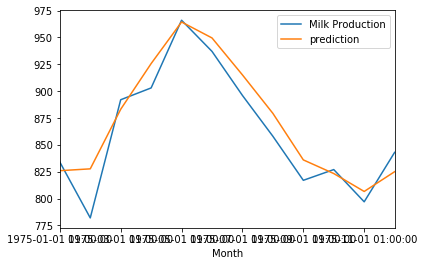

In [14]:
test_df = sample_data.tail(12)
test_df['prediction'] = pred

test_df.plot()


## Manual Implementation of single cells 
#### Simple RNN
#### GRU
#### LSTM

In [ ]:
"""
Implementation of single cell for simple RNN, LSTM, and GRU
"""

class SingleRNNCellExamples:
    def __init__(self, input_vocab_size, embedding_dim, n_hid):
        #self.embedding = tf.Variable(tf.random_uniform([input_vocab_size, embedding_dim]))
        self.n_hid = n_hid
        
        # SimpleRNN
        self.rnn_W = weight_variable('rnn_W', [embedding_dim + n_hid, n_hid])
        self.rnn_b = bias_variable('rnn_b', [n_hid])
        
        # GRU
        self.gru_W_h = weight_variable('gru_W_h', [embedding_dim + n_hid, n_hid])
        self.gru_b_h = bias_variable('gru_b_h', [n_hid])
        
        self.gru_W_r = weight_variable('gru_W_r', [embedding_dim + n_hid, n_hid])
        self.gru_b_r = bias_variable('gru_b_r', [n_hid])
        
        self.gru_W_u = weight_variable('gru_W_u', [embedding_dim + n_hid, n_hid])
        self.gru_b_u = bias_variable('gru_b_u', [n_hid])
        
        # LSTM
        self.lstm_W_o = weight_variable('lstm_W_o', [embedding_dim + n_hid, n_hid])
        self.lstm_b_o = bias_variable('lstm_b_o', [n_hid])
        
        self.lstm_W_u = weight_variable('lstm_W_u', [embedding_dim + n_hid, n_hid])
        self.lstm_b_u = bias_variable('lstm_b_u', [n_hid])    
 
        self.lstm_W_f = weight_variable('lstm_W_f', [embedding_dim + n_hid, n_hid])
        self.lstm_b_f = bias_variable('lstm_b_f', [n_hid])    
        
        self.lstm_W_h = weight_variable('lstm_W_h', [embedding_dim + n_hid, n_hid])
        self.lstm_b_h = bias_variable('lstm_b_h', [n_hid])
        
    def _rnn(self, x, hid, activation=tf.nn.tanh):
        _input = tf.concat([x, hid], -1)
        return activation(tf.matmul(_input, self.rnn_W) + self.rnn_b)
    
    def _gru(self, x, hid):
        _input = tf.concat([x, hid], -1)
        relevance_gate = tf.nn.sigmoid(tf.matmul(_input, self.gru_W_r) + self.gru_b_r)
        update_gate = tf.nn.sigmoid(tf.matmul(_input, self.gru_W_u) + self.gru_b_u)
        
        scaled_input = tf.concat([x, tf.multiply(relevance_gate, hid)], -1)
        candidate_hid = tf.nn.sigmoid(tf.matmul(scaled_input, self.gru_W_h) + self.gru_b_h) 
        
        return update_gate * candidate_hidden + (tf.ones_like(update_gate) - update_gate) * hid
    
    def _lstm(self, x, hid):
        _input = tf.concat([x, hid], -1)
        candidate_hid = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_h) + self.lstm_b_h)
        
        update_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_u) + self.lstm_b_u)
        forget_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_f) + self.lstm_b_f)
        output_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_o) + self.lstm_b_o)
        
        hid = update_gate * candidate_hid + forget_gate * hid
        return output_gate * tf.nn.tanh(hid)